In [1]:
# Alberto Bejarano (2025)
# openFDA_UMAP_v06
# pip install nbqa flake8
# nbqa flake8 openFDA_UMAP_v06.ipynb --select=F401

In [2]:
# This Jupyter notebook processes FDA adverse event data for a set of antibody-drug conjugates (ADCs). It first retrieves data using an API and extracts relevant
# details about the types of adverse events for each drug. The data is then aggregated, grouped by drug and event, and pivoted into a table format for further analysis.
# The notebook applies data scaling and dimensionality reduction techniques, such as Principal Component Analysis (PCA), to standardize and reduce the dimensionality 
# of the dataset. It uses clustering (Leiden algorithm) to group similar data points and explores the relationships between the drugs and their adverse events.
# Finally, the notebook visualizes the results using UMAP, providing insights into the patterns and associations between ADCs and the severity of their associated adverse events.

In [3]:
import warnings
from anndata._core.aligned_df import ImplicitModificationWarning
warnings.simplefilter("ignore", ImplicitModificationWarning)

In [4]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

April 12, 2025 02:04:25


In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = 200
#         .         .         .         .         .         .         .         .
import requests, time, matplotlib, contextlib, os
from IPython.display import Audio, display

In [6]:
import scanpy as sc
sc.settings.seed = 42

In [7]:
drug_names       = ["Kadcyla", "Adcetris", "Polivy", "Enhertu", "Trodelvy"]               # List of ADC drugs
adv_event_filter = ['Febrile neutropenia', 'Diarrhoea', 'Myelosuppression', 'Myalgia']

In [8]:
url = "https://api.fda.gov/drug/event.json"

In [9]:
total_records = 10000
batch_size    = 1000

In [10]:
def safe_request(url, params, retries=3, delay=5):
    for i in range(retries):
        try:
            response = requests.get(url, params=params, timeout=30)
            
            if not response or response.status_code != 200:
                #print(f"Request failed with status code {response.status_code} for batch {params.get('skip', '?')}")
                continue
            return response
            
        except requests.exceptions.ReadTimeout:
            #print(f"Timeout on batch {params.get('skip', '?')} for drug {params['search']}. Retrying ({i+1}/{retries})...")
            time.sleep(delay)
            
        except requests.exceptions.RequestException as e:
            #print(f"Request failed: {e}")
            break
            
    return None  # All retries failed

In [11]:
all_records = []

In [12]:
for drug_name in tqdm(drug_names):
    for skip in range(0, total_records, batch_size):
        params = {"search": f"patient.drug.medicinalproduct:{drug_name}", "limit": batch_size, "skip": skip}
        response = safe_request(url, params)
        
        if not response:
            continue  # Skip failed attempt

        # Debugging: Check if the response has data
        #print(f"Fetched {len(response.json().get('results', []))} records for drug {drug_name}, skip {skip}.")

        data = response.json(); results = data.get("results", [])
        
        if not results:
            print(f"No data returned for batch {skip}.")
            continue  # Skip if no results
        
        for result in results:
            
            seriousness = {
                "Death":           int(result.get("seriousnessdeath", 0)),
                "Hospitalization": int(result.get("seriousnesshospitalization", 0)),
                "LifeThreatening": int(result.get("seriousnesslifethreatening", 0)),
                "Other":           int(result.get("seriousnessother", 0))}
            
            for reaction in result.get("patient", {}).get("reaction", []):
                record = {"ADC_Name": drug_name, "Adverse_Event": reaction.get("reactionmeddrapt", "Unknown"), **seriousness}
                all_records.append(record)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
df = pd.DataFrame(all_records)
print(len(df)); df.sample(3)

68515


,ADC_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other
44001,Polivy,Disease progression,2,2,2,1
44989,Polivy,Febrile neutropenia,2,1,2,1
63863,Enhertu,Nerve injury,2,2,2,2


In [14]:
# Aggregate total counts for each seriousness flag by Adverse Event and ADC Name
agg = df.groupby(["ADC_Name", "Adverse_Event"]).sum(numeric_only=True)
agg["Total"] = agg.sum(axis=1)  # Compute the 'Total' column across all seriousness flags for each Adverse Event and ADC
agg_reset = agg.reset_index()  # Reset index to flatten the DataFrame (remove multi-level index)
agg_reset = agg_reset.sort_values(by='Total', ascending=False)
print(len(agg_reset));agg_reset.head(5)

7123


,ADC_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total
2835,Enhertu,Nausea,1338,1243,1457,1258,5296
2664,Enhertu,Interstitial lung disease,1121,1070,1284,1062,4537
5717,Polivy,Disease progression,1133,1274,1291,817,4515
2901,Enhertu,Off label use,945,963,1033,916,3857
2269,Enhertu,Disease progression,804,922,1089,921,3736


In [15]:
#agg_reset = agg_reset[agg_reset['Adverse_Event'].isin(adv_event_filter)]
print(len(agg_reset));agg_reset.head(5)

7123


,ADC_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total
2835,Enhertu,Nausea,1338,1243,1457,1258,5296
2664,Enhertu,Interstitial lung disease,1121,1070,1284,1062,4537
5717,Polivy,Disease progression,1133,1274,1291,817,4515
2901,Enhertu,Off label use,945,963,1033,916,3857
2269,Enhertu,Disease progression,804,922,1089,921,3736


In [16]:
# Normalizes the Death, Hospitalization, and LifeThreatening columns within each drug (ADC Name), ensuring their values sum to 100%.
# It groups the data by drug, calculates the total for each seriousness column, and then divides each value by its respective total, multiplying by 100 to get percentages.
# It then drops the temporary total column and fills any NaN values.

# Step 1: Group by 'ADC Name' and sum each seriousness column
agg_reset['Total_Seriousness'] = agg_reset.groupby('ADC_Name')[['Death', 'Hospitalization', 'LifeThreatening']].transform('sum').sum(axis=1)

# Step 2: Normalize each column by dividing by the sum of that column for each drug
for col in ['Death', 'Hospitalization', 'LifeThreatening']:
    agg_reset[f'%{col}'] = agg_reset[col] * 100 / agg_reset.groupby('ADC_Name')[col].transform('sum')

# Step 3: Drop the temporary 'Total Seriousness' column
agg_reset = agg_reset.drop(columns=['Total_Seriousness'])

# Fill NaN values (if any)
agg_reset = agg_reset.fillna(0)

# Print the length and preview the updated DataFrame
print(len(agg_reset))
agg_reset.head(5)

7123


,ADC_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening
2835,Enhertu,Nausea,1338,1243,1457,1258,5296,5.33,5.19,5.17
2664,Enhertu,Interstitial lung disease,1121,1070,1284,1062,4537,4.46,4.47,4.55
5717,Polivy,Disease progression,1133,1274,1291,817,4515,11.60,10.76,10.51
2901,Enhertu,Off label use,945,963,1033,916,3857,3.76,4.02,3.66
2269,Enhertu,Disease progression,804,922,1089,921,3736,3.20,3.85,3.86


In [17]:
agg_reset_2 = agg_reset[['ADC_Name', 'Adverse_Event', '%Death', '%Hospitalization']]
agg_reset_2.head(3)

,ADC_Name,Adverse_Event,%Death,%Hospitalization
2835,Enhertu,Nausea,5.33,5.19
2664,Enhertu,Interstitial lung disease,4.46,4.47
5717,Polivy,Disease progression,11.60,10.76


In [18]:
pivot_df = agg_reset_2.pivot_table(index='ADC_Name', columns='Adverse_Event', values='%Death', aggfunc='sum', fill_value=0)
pivot_df = pivot_df.reset_index()
print(len(pivot_df)); pivot_df.head(3)

5


Adverse_Event,ADC_Name,ABASIA,ABDOMINAL DISTENSION,ABDOMINAL PAIN,ACIDOSIS,ACTINOMYCES TEST POSITIVE,ACUTE GRAFT VERSUS HOST DISEASE IN INTESTINE,ACUTE GRAFT VERSUS HOST DISEASE IN SKIN,ACUTE HEPATIC FAILURE,ACUTE RESPIRATORY DISTRESS SYNDROME,ACUTE RESPIRATORY FAILURE,ALANINE AMINOTRANSFERASE INCREASED,ALLERGIC RESPIRATORY SYMPTOM,ALOPECIA,AMNESIA,ANAEMIA,ANAPHYLACTIC REACTION,ANAPLASTIC LARGE CELL LYMPHOMA T- AND NULL-CELL TYPES,ANXIETY,AORTIC ARTERIOSCLEROSIS,ARRHYTHMIA,ASPARTATE AMINOTRANSFERASE INCREASED,ASTHENIA,ATELECTASIS,Abasia,Abdominal abscess,Abdominal adhesions,Abdominal cavity drainage,Abdominal compartment syndrome,Abdominal discomfort,Abdominal distension,Abdominal incarcerated hernia,Abdominal infection,Abdominal lymphadenopathy,Abdominal mass,Abdominal neoplasm,Abdominal pain,Abdominal pain lower,Abdominal pain upper,Abdominal rebound tenderness,Abdominal rigidity,Abdominal sepsis,Abdominal symptom,Abdominal tenderness,Abdominal wall disorder,Abdominal wall haematoma,Abnormal behaviour,Abnormal dreams,Abnormal faeces,Abnormal loss of weight,Abnormal menstrual clots,Abnormal weight gain,Abortion,Abortion induced,Abortion spontaneous,Abscess,Abscess bacterial,Abscess intestinal,Abscess limb,Acanthamoeba infection,Acarodermatitis,Accident,Accidental exposure to product,Accidental overdose,Acetabulum fracture,Acid base balance abnormal,Acidosis,Acne,Acne cystic,Acne pustular,Acquired ATTR amyloidosis,Acquired Von Willebrand^s disease,Acquired diaphragmatic eventration,Acquired gene mutation,Acquired haemophilia,Acquired left ventricle outflow tract obstruction,Activated partial thromboplastin time prolonged,Activities of daily living impaired,Acute abdomen,Acute chest syndrome,Acute coronary syndrome,Acute disseminated encephalomyelitis,Acute febrile neutrophilic dermatosis,Acute generalised exanthematous pustulosis,Acute graft versus host disease,Acute graft versus host disease in skin,Acute hepatic failure,Acute interstitial pneumonitis,Acute kidney injury,Acute leukaemia,Acute lung injury,Acute lymphocytic leukaemia,Acute motor axonal neuropathy,Acute motor-sensory axonal neuropathy,Acute myeloid leukaemia,Acute myeloid leukaemia refractory,Acute myocardial infarction,Acute polyneuropathy,Acute promyelocytic leukaemia,Acute psychosis,...,Vasculitis necrotising,Vasodilatation,Vasogenic cerebral oedema,Vasospasm,Vein collapse,Vein disorder,Vein rupture,Vena cava thrombosis,Venoocclusive disease,Venoocclusive liver disease,Venous haemorrhage,Venous injury,Venous stenosis,Venous thrombosis,Venous thrombosis limb,Ventricular dysfunction,Ventricular extrasystoles,Ventricular fibrillation,Ventricular hypokinesia,Ventricular tachycardia,Vertebral lesion,Vertebroplasty,Vertigo,Vertigo positional,Vessel puncture site bruise,Vessel puncture site haemorrhage,Vessel puncture site pain,Vestibular disorder,Viraemia,Viral diarrhoea,Viral haemorrhagic cystitis,Viral infection,Viral upper respiratory tract infection,Vision blurred,Visual acuity reduced,Visual acuity reduced transiently,Visual impairment,Vital functions abnormal,Vitamin B12 deficiency,Vitamin D decreased,Vitamin D deficiency,Vitiligo,Vitreous detachment,Vitreous floaters,Vitreous haemorrhage,Vocal cord disorder,Vocal cord dysfunction,Vocal cord paralysis,Vogt-Koyanagi-Harada disease,Volvulus,Vomiting,Vomiting projectile,Vulval cancer,Vulval disorder,Vulvovaginal burning sensation,Vulvovaginal candidiasis,Vulvovaginal discomfort,Vulvovaginal dryness,Vulvovaginal pain,Vulvovaginal pruritus,Vulvovaginitis,WHITE BLOOD CELL COUNT DECREASED,WHITE BLOOD CELL COUNT INCREASED,Waldenstrom^s macroglobulinaemia,Walking aid user,Walking disability,Wallerian degeneration,Water intoxication,Weight abnormal,Weight decreased,Weight fluctuation,Weight gain poor,Weight increased,Weight loss poor,Wheelchair user,Wheezing,White blood cell count abnormal,White blood cell count decreased,White blood cell count increased,White blood cell disorder,White coat hypertension,Withdrawal synd

In [19]:
# Drop 'ADC Name' for scaling and keep it for later
adc_names = pivot_df['ADC_Name']
pivot_df2  = pivot_df.drop(columns=['ADC_Name'])
print(len(pivot_df2)); pivot_df2.head(3)

5


Adverse_Event,ABASIA,ABDOMINAL DISTENSION,ABDOMINAL PAIN,ACIDOSIS,ACTINOMYCES TEST POSITIVE,ACUTE GRAFT VERSUS HOST DISEASE IN INTESTINE,ACUTE GRAFT VERSUS HOST DISEASE IN SKIN,ACUTE HEPATIC FAILURE,ACUTE RESPIRATORY DISTRESS SYNDROME,ACUTE RESPIRATORY FAILURE,ALANINE AMINOTRANSFERASE INCREASED,ALLERGIC RESPIRATORY SYMPTOM,ALOPECIA,AMNESIA,ANAEMIA,ANAPHYLACTIC REACTION,ANAPLASTIC LARGE CELL LYMPHOMA T- AND NULL-CELL TYPES,ANXIETY,AORTIC ARTERIOSCLEROSIS,ARRHYTHMIA,ASPARTATE AMINOTRANSFERASE INCREASED,ASTHENIA,ATELECTASIS,Abasia,Abdominal abscess,Abdominal adhesions,Abdominal cavity drainage,Abdominal compartment syndrome,Abdominal discomfort,Abdominal distension,Abdominal incarcerated hernia,Abdominal infection,Abdominal lymphadenopathy,Abdominal mass,Abdominal neoplasm,Abdominal pain,Abdominal pain lower,Abdominal pain upper,Abdominal rebound tenderness,Abdominal rigidity,Abdominal sepsis,Abdominal symptom,Abdominal tenderness,Abdominal wall disorder,Abdominal wall haematoma,Abnormal behaviour,Abnormal dreams,Abnormal faeces,Abnormal loss of weight,Abnormal menstrual clots,Abnormal weight gain,Abortion,Abortion induced,Abortion spontaneous,Abscess,Abscess bacterial,Abscess intestinal,Abscess limb,Acanthamoeba infection,Acarodermatitis,Accident,Accidental exposure to product,Accidental overdose,Acetabulum fracture,Acid base balance abnormal,Acidosis,Acne,Acne cystic,Acne pustular,Acquired ATTR amyloidosis,Acquired Von Willebrand^s disease,Acquired diaphragmatic eventration,Acquired gene mutation,Acquired haemophilia,Acquired left ventricle outflow tract obstruction,Activated partial thromboplastin time prolonged,Activities of daily living impaired,Acute abdomen,Acute chest syndrome,Acute coronary syndrome,Acute disseminated encephalomyelitis,Acute febrile neutrophilic dermatosis,Acute generalised exanthematous pustulosis,Acute graft versus host disease,Acute graft versus host disease in skin,Acute hepatic failure,Acute interstitial pneumonitis,Acute kidney injury,Acute leukaemia,Acute lung injury,Acute lymphocytic leukaemia,Acute motor axonal neuropathy,Acute motor-sensory axonal neuropathy,Acute myeloid leukaemia,Acute myeloid leukaemia refractory,Acute myocardial infarction,Acute polyneuropathy,Acute promyelocytic leukaemia,Acute psychosis,Acute pulmonary oedema,...,Vasculitis necrotising,Vasodilatation,Vasogenic cerebral oedema,Vasospasm,Vein collapse,Vein disorder,Vein rupture,Vena cava thrombosis,Venoocclusive disease,Venoocclusive liver disease,Venous haemorrhage,Venous injury,Venous stenosis,Venous thrombosis,Venous thrombosis limb,Ventricular dysfunction,Ventricular extrasystoles,Ventricular fibrillation,Ventricular hypokinesia,Ventricular tachycardia,Vertebral lesion,Vertebroplasty,Vertigo,Vertigo positional,Vessel puncture site bruise,Vessel puncture site haemorrhage,Vessel puncture site pain,Vestibular disorder,Viraemia,Viral diarrhoea,Viral haemorrhagic cystitis,Viral infection,Viral upper respiratory tract infection,Vision blurred,Visual acuity reduced,Visual acuity reduced transiently,Visual impairment,Vital functions abnormal,Vitamin B12 deficiency,Vitamin D decreased,Vitamin D deficiency,Vitiligo,Vitreous detachment,Vitreous floaters,Vitreous haemorrhage,Vocal cord disorder,Vocal cord dysfunction,Vocal cord paralysis,Vogt-Koyanagi-Harada disease,Volvulus,Vomiting,Vomiting projectile,Vulval cancer,Vulval disorder,Vulvovaginal burning sensation,Vulvovaginal candidiasis,Vulvovaginal discomfort,Vulvovaginal dryness,Vulvovaginal pain,Vulvovaginal pruritus,Vulvovaginitis,WHITE BLOOD CELL COUNT DECREASED,WHITE BLOOD CELL COUNT INCREASED,Waldenstrom^s macroglobulinaemia,Walking aid user,Walking disability,Wallerian degeneration,Water intoxication,Weight abnormal,Weight decreased,Weight fluctuation,Weight gain poor,Weight increased,Weight loss poor,Wheelchair user,Wheezing,White blood cell count abnormal,White blood cell count decreased,White blood cell count increased,White blood cell disorder,White coat hypertension,W

In [20]:
# Keep a numeric-only version
df_numeric       = pivot_df2.select_dtypes(include='number').copy()
df_numeric       = df_numeric.apply(pd.to_numeric, errors='coerce', downcast='float')
pivot_df.index   = pivot_df2.index.astype(str)
df_numeric.index = df_numeric.index.astype(str)
print(df_numeric.shape); print(df_numeric.max().max())

(5, 3601)
14.069296836853027


In [21]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        from anndata._core.aligned_df import ImplicitModificationWarning
        warnings.simplefilter("ignore", ImplicitModificationWarning)

        # Flatten MultiIndex if present and reset index
        df_numeric = pivot_df2.select_dtypes(include='number').copy()
        if isinstance(df_numeric.index, pd.MultiIndex):
            df_numeric = df_numeric.reset_index(drop=True)

        # Reset index on pivot_df to ensure alignment
        pivot_df = pivot_df.reset_index(drop=True)

        # Create AnnData object
        adata_temp = sc.AnnData(df_numeric)
        adata_temp.obs['ADC_Name'] = pivot_df['ADC_Name'].values
        
        # Running PCA and Leiden
        sc.pp.pca(adata_temp)
        sc.pp.neighbors(adata_temp)
        sc.tl.leiden(adata_temp, resolution=1.00, key_added="leiden_1.00", flavor="igraph", n_iterations=2, directed=False)

CPU times: total: 14 s
Wall time: 13.4 s


In [22]:
# Ensure that 'ADC_Name' is correctly mapped to categorical values (for discrete colors)
adata_temp.obs['ADC_Name'] = adata_temp.obs['ADC_Name'].astype('category')

In [23]:
# Define UMAP parameters for exploration
MIN_DISTS = [1, 3, 5, 10]               # Adjusted values for min_dist
SPREADS   = [0.5, 1, 5, 10]             # Adjusted values for spread

  0%|          | 0/16 [00:00<?, ?it/s]

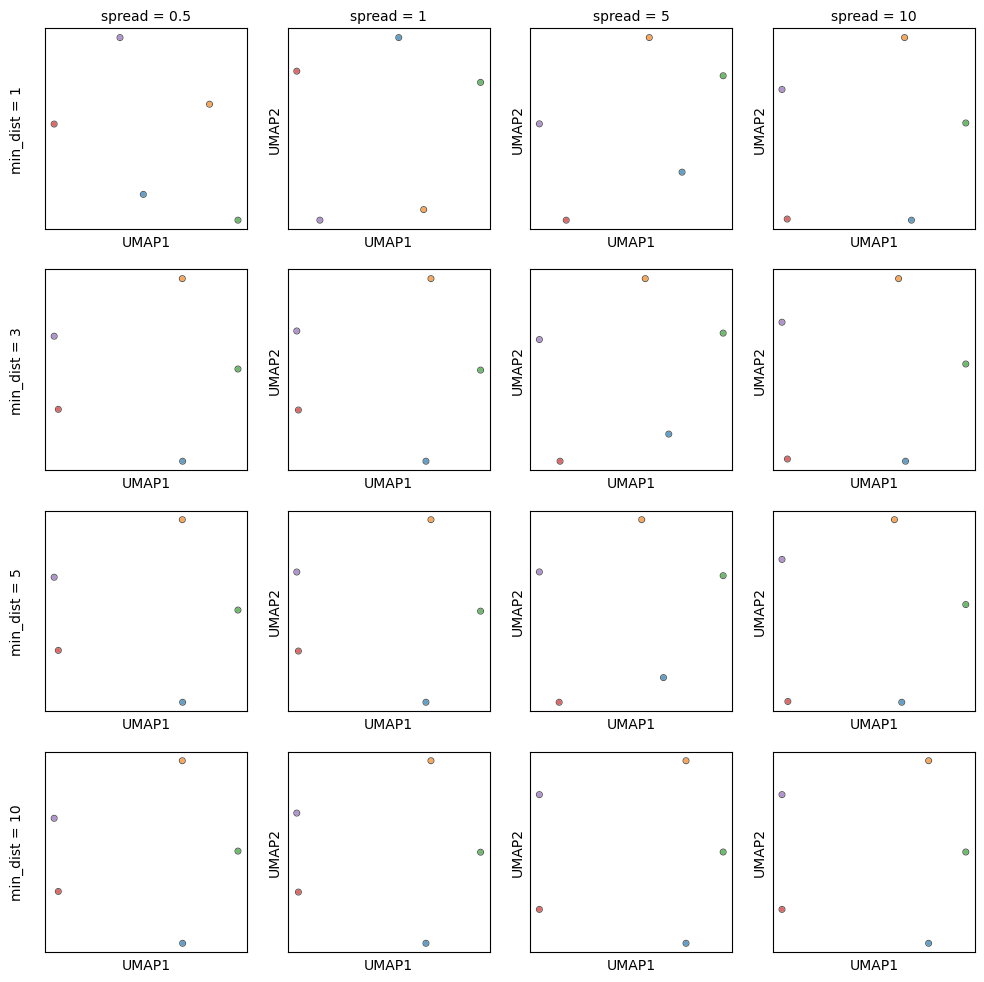

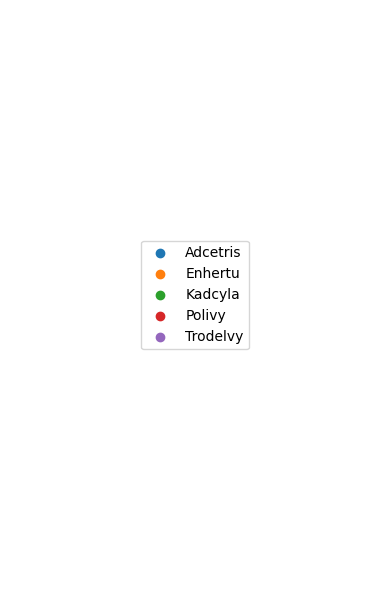

<Figure size 640x480 with 0 Axes>

In [24]:
# Create a figure for UMAP plots (subplots)
fig, axes = plt.subplots(len(MIN_DISTS), len(SPREADS), figsize=(12, 12))

# Loop through all combinations of MIN_DIST and SPREAD
for (i, min_dist), (j, spread) in tqdm(product(enumerate(MIN_DISTS), enumerate(SPREADS)), total=len(MIN_DISTS) * len(SPREADS)):
    ax = axes[i][j]  # Get the subplot axis
    
    # Create the parameter string to display in the title
    param_str = f"min_dist = {min_dist}, spread = {spread}"
    
    # Recompute UMAP with new parameters, suppressing warnings/output
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
    
    # Define the discrete colormap (tab20 or you can use other discrete colormaps)
    #cmap = matplotlib.cm.get_cmap('tab20', len(adata_temp.obs['ADC_Name'].cat.categories))  # Get discrete colormap
    cmap = matplotlib.colormaps.get_cmap('tab20')
    #cmap = matplotlib.colormaps['tab20']  # Access colormap directly
    
    # Plot UMAP with discrete coloring
    kws = {'s': 50, 'add_outline': True, 'outline_width': (0.2, 0.01), 'outline_color': ('#545955', 'white')}
    sc.pl.umap(adata_temp, title='', color='ADC_Name', cmap=cmap, legend_loc='right margin', show=False, sort_order=False, **kws, ax=ax)
    
    # Set the Y-axis label (min_dist values on the left-hand side)
    if j == 0:  # First column, left-most subplots
        ax.set_ylabel(f"min_dist = {min_dist}", fontsize=10, rotation=90, labelpad=15)
    
    # Set the title for the top row (spread values)
    if i == 0:  # First row, top-most subplots
        ax.set_title(f"spread = {spread}", fontsize=10)

# Create an empty plot and copy the legend from the UMAP plot
fig_legend, ax_legend = plt.subplots(figsize=(4, 6))

# Get the legend from the last UMAP plot (e.g., the last subplot)
handles, labels = axes[-1][-1].get_legend_handles_labels()

# Remove the legend from the original UMAP plot
for ax in axes.flatten():
    ax.legend_.remove()

# Plot the copied legend on the empty plot
ax_legend.legend(handles, labels, loc='center')
ax_legend.axis('off')  # Remove axes for a clean legend-only plot

# Save the legend-only plot
fig_legend.tight_layout()
plt.savefig("UMAP_Legend_Only.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Adjust layout and save the UMAP figure again without the legend
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave space for Y-axis labels
plt.savefig("UMAP_Exploration_Discrete_Colors_No_Legend.png", format="png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

In [25]:
# Path to your audio file
audio_file = "./data/clock-chime-88027.mp3"
display(Audio(audio_file, autoplay=True))

In [26]:
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print("'GSE279781_DEG_Clusters_v02' script run time:", f"{int(minutes)} min {int(seconds)} sec.")

'GSE279781_DEG_Clusters_v02' script run time: 3 min 13 sec.
